# Show and Tell v23

In [1]:
!pip install torch
!pip install torch torchvision transformers
!pip install --upgrade transformers
!pip install matplotlib
!pip install nltk
!pip install tensorflow
!pip install msgpack

import os
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from collections import Counter
from itertools import chain
from PIL import Image
import random
from transformers import ViTFeatureExtractor, ViTModel
from transformers import SwinForImageClassification
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import gzip
import msgpack

In [2]:
# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
print(torch.version.cuda)


11.8


In [4]:
# For PyTorch
import torch
print(torch.cuda.is_available())

# For TensorFlow
import tensorflow as tf
print(tf.test.is_gpu_available())


True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


# Dataset Class

Below we have defined the dataset class, which shall be used throughout the project to access the images, and their respective captions. 

In [5]:
trainSize = 8192
valSize = 1024
batchSize = 32
num_epochs = 10
num_captions = 3

In [6]:
class CustomCocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        # Create a mapping from image IDs to filenames
        self.id_to_filename = {item['id']: item['file_name'] for item in self.data['images']}

        # Create a mapping from image IDs to captions
        # Note that there might be multiple captions per image
        self.id_to_captions = {}
        for annotation in self.data['annotations']:
            image_id = annotation['image_id']
            if image_id not in self.id_to_captions:
                self.id_to_captions[image_id] = []
            self.id_to_captions[image_id].append(annotation['caption'])

        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # Retrieve the image info
        image_info = self.data['images'][idx]
        image_id = image_info['id']
        img_filename = self.id_to_filename[image_id]

        # Load the image
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Retrieve the corresponding captions
        captions = self.id_to_captions[image_id][:num_captions]
        return image, captions

Here we define a function to transform the dimensions and format of all the images to make them consistent in order to properly input them into the SWIN Transformer. 

In [7]:
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

# transform_train = transforms.Compose([
#     transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),  # Resize using BICUBIC interpolation
#     transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
#     transforms.RandomRotation(degrees=15),  # Randomly rotate the image by +/- 15 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
#     transforms.RandomGrayscale(p=0.1),  # Convert images to grayscale with a probability of 10%
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.99, 1.01)),  # Randomly crop the image
#     transforms.RandomPerspective(distortion_scale=0.05, p=0.5),  # Random perspective transformation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.RandomErasing(p=0.2),  # Randomly erase a portion of the image
# ])

transform_train = transforms.Compose([
    # transforms.RandomGrayscale(p=0.2),  # 0.2 prob of grayscale
    # transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    # transforms.RandomRotation(degrees=15),  # Rotate every image by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply color jitter to every image
    # transforms.RandomErasing(p=1.0),  # Erase a random part of every image
    
    transforms.Resize(256),  
    transforms.CenterCrop(224),  # Crop to the required size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),  # Crop to the required size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Data Loader and Dataset Initialization

Hyperparameters. 

The training dataset is about 118k images large, but all of it has not been used due to computational limitations. Batchsize and Epochs can also be increased given additional computational capacity. 

Initialize the dataset, including the train and validation data, and their respective captions, found in the .json files. Test data has not been used as it does not contain any captions, but the validation dataset shall serve as the test dataset for all intents and purposes. As a result, any validation/development to be done shall be performed on a subset of the train dataset which shall be disjoint from the data trained on. 

IID Sampling has been performed on the dataset in order to ensure that the subset selected does not contain any class imbalances. Further, the "shuffle" parameter has been turned to True within the data loader, thus each time the model is trained, samples are provided in a random order to reduce the chance of overfitting. 

In [8]:
# Initialize the dataset with the feature extractor
coco_dataset = CustomCocoDataset(
    root_dir='train2017',
    annotation_file='captions_train2017.json',
    transform=transform_train
)

coco_val_dataset = CustomCocoDataset(
    root_dir='val2017',
    annotation_file='captions_val2017.json',
    transform=transform_val
)

random.seed = 42

# Shuffle the indices
indices = list(range(len(coco_dataset)))
random.shuffle(indices)

# Take a subset of the first 2048 items
subset_indices = indices[:trainSize]
coco_dataset = Subset(coco_dataset, subset_indices)

val_indices = list(range(len(coco_val_dataset)))
random.shuffle(val_indices)
subset_val_indices = val_indices[:valSize]
coco_val_dataset = Subset(coco_val_dataset, subset_val_indices)

# DataLoader
data_loader = DataLoader(dataset=coco_dataset, batch_size=batchSize, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=coco_val_dataset, batch_size=batchSize, shuffle=True, num_workers=0)

# Testing Data Loader

This function shall allow for images within the dataset to be displayed in the notebook. 

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.axis('off')  # This line hides the axis
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

You can test if the data loader is working by running the below code block. It takes in one batch of images, and displays the first one from the batch. 

Size of the batch (images): torch.Size([32, 3, 224, 224])
Number of captions in this batch: 32


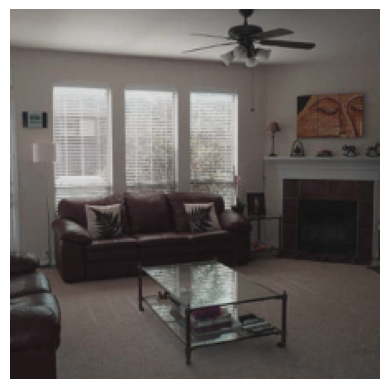

In [10]:
# Fetch one batch of images
for images, captions in data_loader:
    break

# If you want to display the size of this batch or perform any simple operation
print(f"Size of the batch (images): {images.size()}")
print(f"Number of captions in this batch: {len(captions[0])}")

imshow(images[0])

# Preprocess Captions

The 'preprocess_captions' function takes as argument the data loader, and while iterating through all the captions, prepends a start token 'startword' and appends an end token 'endword' to each caption. They are also changed to lowercase, and tokenized using .split(). 

A vocabulary is constructed from the captions, consisting of every word that occurs once or more (basically, all of them!)

In [11]:
nltk.download('punkt')

def preprocess_captions(data_loader):
    captions = []
    for _, caps in data_loader:        
        for cap_num in range(len(caps)):
            for batch_id in range(len(caps[0])):
                updated_cap = f'startword {caps[cap_num][batch_id].lower()} endword'
    
                # Tokenize the updated caption
                tokens = updated_cap.split()
                captions.append(tokens)

    word_count = Counter()
    # Build a vocabulary
    for cap in captions:
        word_count.update(cap)

    min_word_freq = 1

    vocab = [word for word in word_count if word_count[word] >= min_word_freq]

    # Create a tokenizer and fit it on the updated captions
    tokenizer = Tokenizer(num_words=len(vocab))
    tokenizer.fit_on_texts([" ".join(caption) for caption in captions])
    return tokenizer, word_count, vocab

tokenizer, word_count, vocab = preprocess_captions(data_loader)

[nltk_data] Downloading package punkt to C:\Users\xlab-
[nltk_data]     shared\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The code below is used during inference, helping convert token indices back to words. 

In [12]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# Function to convert a list of indices to words
def indices_to_words(indices):
    return ' '.join([index_to_word.get(index, '') for index in indices])

# Evaluation Script

Below is a code block to be used for evaluation, that takes as input a list containing predicted captions, and a list containing true captions. 

The metric used is the BLEU score. It has been used in several literature, such as: 

1. Show and Tell: A Neural Image Caption Generator
2. Show, Attend and Tell: Neural Image Caption Generation with Visual Attention
3. Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering

The BLEU (Bilingual Evaluation Understudy) Score is a widely used metric for evaluating the quality of machine-translated text against high-quality human translations. Its extensive use in research is attributed to its ability to provide a standardized, objective, and quantitative measure of translation quality. BLEU score efficiently correlates with human judgment, particularly at the corpus level, making it a valuable tool for assessing the overall translation quality.

In the realm of image captioning, BLEU is utilized to assess how closely a model's generated captions align with human-generated reference captions. This metric is crucial not only for verifying the factual correctness of the captions but also for ensuring linguistic similarity to human expression.

We have calculated 2 different kinds of BLEU score. Below stated are the advantages and disadvantages of each, along with why they have been used: 

When comparing individual caption scoring (sentence-level BLEU) and overall corpus scoring (corpus-level BLEU), there are notable differences. Sentence-level BLEU evaluates each generated caption against its reference, averaging these scores for a final result. This method, while insightful for individual translations, can be sensitive to caption length and may not consistently align with human judgment. On the other hand, corpus-level BLEU calculates the score over the entire dataset. This approach considers all n-grams in the generated corpus, providing a more comprehensive assessment of the model's performance. Corpus-level BLEU is typically more stable and accurately reflects the system's effectiveness, making it the preferred method for evaluating and comparing the performance of translation or captioning systems.

FInally, a smoothing function has been used to ensure that if any n-gram is not present at all, the entire BLEU score does not drop to 0 (as it is computed using a geometric series of all the n-grams from 1 to 4). 

In [13]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate(predictions, true_labels):
    chencherry = SmoothingFunction()
    scores = []

    # Each group of three items in true_labels corresponds to the three captions of one image
    for i in range(len(predictions)):
        # Extract the three reference captions for the current image
        start_idx = i * 3
        end_idx = start_idx + 3
        truths = [label.split() for label in true_labels[start_idx:end_idx]]

        pred = predictions[i].split()
        score = sentence_bleu(truths, pred, smoothing_function=chencherry.method3)
        scores.append(score)
    
    # Tokenize the sentences
    tokenized_pred = [pred.split() for pred in predictions]

    # Group every three captions as references for one image
    tokenized_true = [[labels.split() for labels in true_labels[i:i + 3]] for i in range(0, len(true_labels), 3)]

    # Calculate corpus-level BLEU score
    corpus_score = corpus_bleu(tokenized_true, tokenized_pred)

    print("Maximum BLEU Score (1-1) = ", max(scores))
    print("Average BLEU Score (1-1) = ", sum(scores)/len(scores))
    print("Corpus BLEU score = ", corpus_score)


# SWIN Transformer

Here, we have initialized a pre-trained Microsoft SWIN Transformer. This model replaces our previous ResNet50, in the bid for better performance through the use of attention based mechanisms over visual regions. 

In [14]:
model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224', output_hidden_states=True)
model = model.to(device)
model.eval()

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [15]:
def extract_features(image):
    """
    Function to extract features from a single image using Swin Transformer.
    :param image: Image tensor with shape (channels, height, width).
    :return: Extracted features.
    """
    image = image.unsqueeze(0)  # Preprocess and add batch dimension
    image = image.to(device)  # Move to the same device as the model

    with torch.no_grad():
        outputs = model(image)
        features = outputs.hidden_states[-1]

    return features.squeeze(0)  # Remove batch dimension

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureTransform(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeatureTransform, self).__init__()
        self.fc1 = nn.Linear(input_size, 14336)
        self.fc2 = nn.Linear(14336, 4096)
        self.fc3 = nn.Linear(4096, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)
feature_transform.eval()  # Set to evaluation mode if not training

feature_mapping = {}

with torch.no_grad():  # Disable gradient computation
    for images, captions in data_loader:
        images = images.to(device)
        for i in range(len(images)):
            features = extract_features(images[i])

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping[tuple([captions[j][i] for j in range(num_captions)])] = features

In [ ]:
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)
feature_transform.eval()  # Set to evaluation mode if not training

feature_mapping_val = {}

with torch.no_grad():  # Disable gradient computation
    for images, captions in val_loader:
        images = images.to(device)

        for i in range(len(images)):
            features = extract_features(images[i])

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping_val[tuple([captions[j][i] for j in range(num_captions)])] = features

# LSTM

This is a unidirectional LSTM that shall be used to predict the captions based on the provided image feature representation.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM hidden state
        self.init_c = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM cell state
        self.word_embeddings = nn.Embedding(vocab_size,embed_dim)

    def forward(self, features, captions):     
        # Initialize hidden and cell states with image features
        h = self.init_h(features)  # Shape: (batch_size, hidden_dim)
        c = self.init_c(features)  # Shape: (batch_size, hidden_dim)

        # Ensure h and c are 3-D: reshape h and c to add the num_layers dimension
        # Assuming a single-layer LSTM, num_layers = 1
        h = h.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)
        c = c.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)

        # Embed the captions
        
        embeddings = self.embed(captions)

        # Pass the embedded captions and states through the LSTM
        lstm_out, _ = self.lstm(embeddings, (h, c))

        # Output layer
        outputs = self.linear(lstm_out)

        return outputs
    
    def infer(self, features, max_len=10):
        features = features.to(device)

        # print("features size: ", features.size())
        batch_size = features.size(0)  # Get the current batch size
        h = self.init_h(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)
        c = self.init_c(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)

        # Initialize the input tensor for LSTM (assuming start with <start> token)
        start_token_index = tokenizer.word_index['startword']
        inputs = self.embed(torch.LongTensor([start_token_index]).to(device)).repeat(batch_size, 1).unsqueeze(1)

        predictions = [[start_token_index] for _ in range(batch_size)]

        for i in range(max_len):
            lstm_out, (h, c) = self.lstm(inputs, (h, c))

            outputs = self.linear(lstm_out.squeeze(1))
            _, predicted = outputs.max(1)
            
            # Iterate over each prediction in the batch
            for idx in range(batch_size):
                # Append each prediction separately
                predictions[idx].append(predicted[idx].item())
            inputs = self.embed(predicted).unsqueeze(1)

        return predictions

# Create the model
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 256
hidden_dim = 512
feature_dim = 2048  # Depending on your feature extractor output
CGLSTM = LSTM(feature_dim, embed_dim, hidden_dim, vocab_size)
CGLSTM = CGLSTM.to(device)

# Training

The training loop is shown below. Cross Entropy Loss has been used, and the loss calculation is defined by comparing the latest generated word to the word that would otherwise be in the ground truth caption. 

Within the following training loop, we have also trained the neural network that is placed between the transformer and LSTM. This shall allow for the features to be resized for the input to the LSTM. 

In [ ]:
CGLSTM = CGLSTM.to(device)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CGLSTM.parameters(), lr=0.001)
# Assuming CGLSTM is your LSTM model
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)

# Define a loss function and an optimizer
# Include both LSTM and FeatureTransform layer parameters in the optimizer
optimizer = torch.optim.Adam(list(CGLSTM.parameters()) + list(feature_transform.parameters()), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch_id, (images, captions) in enumerate(data_loader):
        print(batch_id)
        feature_list = []
        sequences_list = []
        
        for i in range(len(images)):
            features = feature_mapping[tuple([captions[j][i] for j in range(num_captions)])]

            # Convert each group of captions to sequences of integers and pad to 20 tokens
            sequences = tokenizer.texts_to_sequences([captions[j][i] for j in range(num_captions)])
            sequences = pad_sequences(sequences, maxlen=20, padding='post')
            sequences_list.append(sequences)
            
            transformed_features = feature_transform(features.flatten())
            feature_list.append(transformed_features)

        stacked_features = torch.stack(feature_list, dim=0)  # shape: [batch_size, 2048]

        # Convert to PyTorch tensors and stack along a new dimension
        features = torch.tensor(stacked_features, dtype=torch.float32).to(device)
        captions_tensor = torch.stack([torch.tensor(sequences, dtype=torch.long) for sequences in sequences_list], dim=1).to(device)

         # Initialize total loss for the batch
        total_loss = 0.0

        for i in range(num_captions):  # Assuming num_captions is 3
            # Forward pass for the i-th caption
            outputs = CGLSTM(features, captions_tensor[i, :, :-1])  # Process i-th caption

            # Reshape outputs and targets for the loss function
            outputs_reshaped = outputs.view(-1, vocab_size)
            targets = captions_tensor[i, :, 1:].contiguous().view(-1)

            # Calculate the loss for the i-th caption
            loss = criterion(outputs_reshaped, targets)
            total_loss += loss

        # Average the loss over the number of captions
        average_loss = total_loss / num_captions

        # Backward pass and optimize
        optimizer.zero_grad()
        average_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Inference

Inference is performed by the LSTM generating a caption taking into account the start word as the first word, followed by generating each new word with the previous hidden state as the input. In this manner, an entire caption is generated, limited to 10 words. 

In [ ]:
# Inference loop
CGLSTM.eval()
feature_transform.eval()

predictions = []
true_labels = []

for batch_id, (images, captions) in enumerate(val_loader):
        feature_list = []

        for i in range(len(images)): 
            features = feature_mapping_val[tuple([captions[j][i] for j in range(num_captions)])]
            transformed_features = feature_transform(features.flatten())
            feature_list.append(transformed_features)

        # Since feature_list now contains tensors, this should work
        stacked_features = torch.stack(feature_list, dim=0)
        features = stacked_features.to(device)

        caption_indices = CGLSTM.infer(features)
    
        for i, image in enumerate(images):
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]

                caption_words = indices_to_words(caption_indices[i])
                
                pred = caption_words[10:]
                predictions.append(pred)

                truth = []
                for j in range(num_captions): 
                    truth.append(captions[j][i])
                    true_labels.append(captions[j][i])
                    
	        # Print the true and predicted captions along with the image
                if batch_id == 0 and i < 20: 
                    print("True: ", truth)
                    print("Predicted: ", pred)
                    imshow(image)

In [ ]:
evaluate(predictions, true_labels)